In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

from bgspy.utils import latex_scientific_notation
from bgspy.utils import load_pickle, mean_ratio, read_bedcov
from bgspy.recmap import RecMap
from bgspy.utils import load_seqlens
from bgspy.nonparametric import Lowess, lowess_bootstrap

In [87]:
def ols_summary(x, digits=2):   
    if digits is not None:
        slope = np.round(x.slope, digits)
    else:
        slope = latex_scientific_notation(x.slope)
    r = x.rvalue
    r2 = np.round(100 * r**2, 1)
    if x.pvalue == 0:
        pv = 0
    else:
        pv = latex_scientific_notation(x.pvalue)
    return f"$\widehat{{\\beta}}_1$ = {slope}, $R^2$ = {r2}%, p-value: {pv}"


In [4]:
#plt.plot()
plt.style.use('./buffalo.mplstyle')

## Revisions

Since revisions are relatively minor, I am putting them in a separate notebook. 

Files generated with: 

    bedtools makewindows -g hg38_seqlens.tsv -w 1000000 | gzip > windows_1Mb.bed.gz
    bedtools coverage -b cadd_top6_percent.bed.gz -a windows_1Mb.bed.gz | gzip > cadd6_1Mbp.bed.gz

In [5]:
sl = load_seqlens('../data/annotation/hg38_seqlens.tsv')
rm = RecMap('../data/fit_annotation/decode_2019_map.txt', sl)

In [6]:
c6 = load_pickle('../new_fits/cadd6__decode/fits/pop_yri/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')

/home/vsb/projects/bprime/bgspy/data.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [7]:
mp = c6['mbp'].bins.midpoints()
resid = c6['mbp'].resid()
B = c6['mbp'].predict(B=True)
pi = c6['mbp'].pi()

In [8]:
allbins = c6['mbp'].bins

In [9]:
local_recrate = dict()
Mb_recrate = dict()
for chrom in sl:
    if chrom == 'chrX': 
        continue
    local_recrate[chrom] = rm.lookup(chrom, np.array(mp[chrom]))
    
    bins = np.array(c6['mbp'].bins.bins()[chrom])
    start = rm.lookup(chrom, bins[:, 0], cumulative=True)
    end = rm.lookup(chrom, bins[:, 1], cumulative=True)
    width = bins[:, 1] - bins[:, 0]
    Mb_recrate[chrom] = (end-start) /  width

In [10]:
local_recrate.keys()

dict_keys(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'])

In [11]:
local_recrates = list(itertools.chain(*local_recrate.values()))

In [12]:
Mb_recrates = list(itertools.chain(*Mb_recrate.values()))

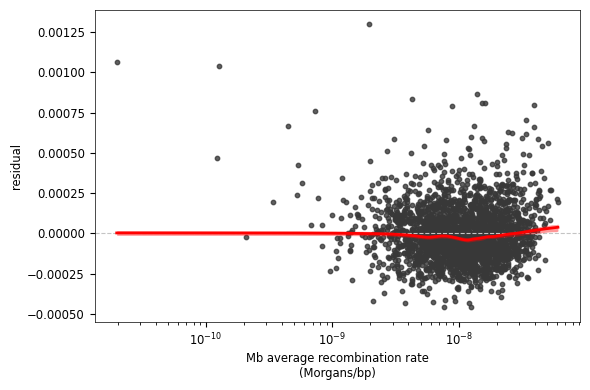

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(Mb_recrates, resid, c='0.22', s=10, alpha=0.8)
ax.semilogx()
ax.axhline(0, c='0.77', linestyle='dashed', linewidth=0.8)
lw = Lowess(0.3)
lw.fit(Mb_recrates, resid)

lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

plt.plot(*lw.pairs(),  c='red', linewidth=2)
ax.set_ylabel('residual')
ax.set_xlabel('Mb average recombination rate\n(Morgans/bp)')
fig.savefig('../manuscript/figures/supplementary/suppfigure_recrate_residual.pdf', 
            bbox_inches='tight')
plt.tight_layout()

In [100]:
cov = read_bedcov('../data/fit_annotation/cadd6_1Mbp.bed.gz')
#cov.set_index(['chrom', 'start', 'end'])
cov8 = read_bedcov('../data/fit_annotation/cadd8_1Mbp.bed.gz')
cds = read_bedcov('../data/fit_annotation/ensembl_CDS_1Mbp.bed.gz')
pc = read_bedcov('../data/fit_annotation/phastcons_1Mbp.bed.gz')

assert cov.shape[0] == cov8.shape[0]
assert cov.shape[0] == cds.shape[0]
assert cov.shape[0] == pc.shape[0]

In [75]:
cov.head()

,chrom,start,end,nfeature,nbases,length_a,frac
0,chr1,0,1000000,10023,34068,1000000,0.034068
1,chr1,1000000,2000000,17955,69224,1000000,0.069224
2,chr1,2000000,3000000,9186,41676,1000000,0.041676
3,chr1,3000000,4000000,12191,56600,1000000,0.056600
4,chr1,4000000,5000000,7089,31176,1000000,0.031176


In [76]:
cov8.head()

,chrom,start,end,nfeature,nbases,length_a,frac
0,chr1,0,1000000,13702,46515,1000000,0.046515
1,chr1,1000000,2000000,19383,76089,1000000,0.076089
2,chr1,2000000,3000000,10533,47313,1000000,0.047313
3,chr1,3000000,4000000,13956,63421,1000000,0.063421
4,chr1,4000000,5000000,8768,38398,1000000,0.038398


In [101]:
cov['frac_8'] = cov8['frac']
cov['frac_cds'] = cds['frac']
cov['frac_pc'] = pc['frac']

In [102]:
d = pd.DataFrame(allbins.flat_bins(), columns=('chrom', 'start', 'end'))
d['resid'] = resid
d['B'] = B
d['recrate'] = Mb_recrates 
d['pi'] = pi
d.set_index(['chrom', 'start', 'end'])
d.head()

,chrom,start,end,resid,B,recrate,pi
0,chr1,1000000,2000000,0.000195,0.500920,3.894731e-09,0.000909
1,chr1,2000000,3000000,-0.000016,0.860676,1.489090e-08,0.001210
2,chr1,3000000,4000000,0.000139,0.901748,4.890751e-08,0.001423
3,chr1,4000000,5000000,0.000205,0.903248,2.477152e-08,0.001491
4,chr1,5000000,6000000,0.000149,0.886551,2.402526e-08,0.001412


In [103]:
d['start'] = d['start'].astype('int64')
d['end'] = d['end'].astype('int64')
merged_df = pd.merge(d, cov, on=['chrom', 'start', 'end'], how='inner')
merged_df['perc'] = merged_df['frac'] * 100
merged_df['perc_8'] = merged_df['frac_8'] * 100
merged_df['perc_cds'] = merged_df['frac_cds'] * 100
merged_df['perc_pc'] = merged_df['frac_pc'] * 100

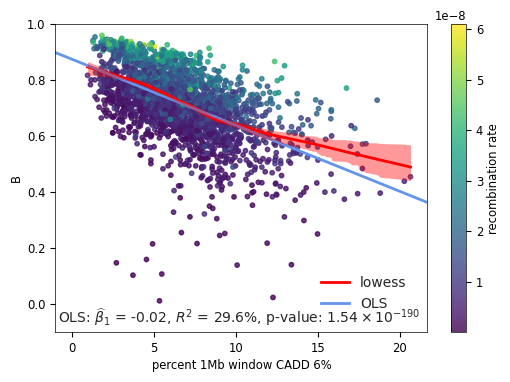

In [65]:
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['perc'], merged_df['B'], s=10, alpha=0.8, c=merged_df['recrate'])

lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['B'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2, label='lowess')

res = stats.linregress(merged_df['perc'], merged_df['B'])
ax.axline((0, res[1]), slope=res[0], linewidth=2, label=f'OLS', c='cornflowerblue')

# Add the regression line to the plot
#ax.plot(xp, xp/1e-8, c='0.77', linestyle='dashed', linewidth=0.8)
ax.text(0.98, 0.03, "OLS: " + ols_summary(res), transform=ax.transAxes, fontsize=10, ha='right')
ax.set_ylim(-0.1, 1)

ax.legend()
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('recombination rate')
ax.set_ylabel('B')
ax.set_xlabel('percent 1Mb window CADD 6%')
fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_B.pdf', bbox_inches='tight')

Text(0.5, 0, 'percent 1Mb window CADD 6%')

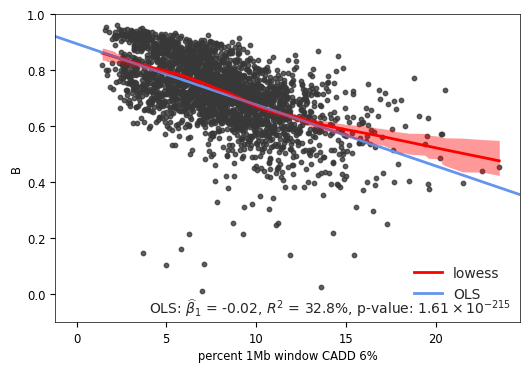

In [64]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(merged_df['perc_8'], merged_df['B'], c='0.22', s=10, alpha=0.8, )
#ax.semilogx()
#ax.axhline(0, c='0.77', linestyle='dashed', linewidth=0.8)
lw = Lowess(0.3)
lw.fit(merged_df['perc_8'], merged_df['B'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

plt.plot(*lw.pairs(),  c='red', linewidth=2, label='lowess')

res = stats.linregress(merged_df['perc_8'], merged_df['B'])

#ax.plot(xp, line, color='cornflowerblue', label=f'OLS')
#ax.plot(xp, xp/1e-8, c='0.77', linestyle='dashed', linewidth=0.8)
ax.text(0.98, 0.03, "OLS: " + ols_summary(res), transform=ax.transAxes, fontsize=10, ha='right')
ax.axline((0, res[1]), slope=res[0], linewidth=2, label=f'OLS', c='cornflowerblue')
ax.set_ylim(-0.1, 1)
ax.legend()
ax.set_ylabel('B')
ax.set_xlabel('percent 1Mb window CADD 8%')
#fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_B_alt.pdf', bbox_inches='tight')

In [19]:
merged_df['recrate_quantile'] = pd.qcut(merged_df['recrate'], q=5, labels=False)

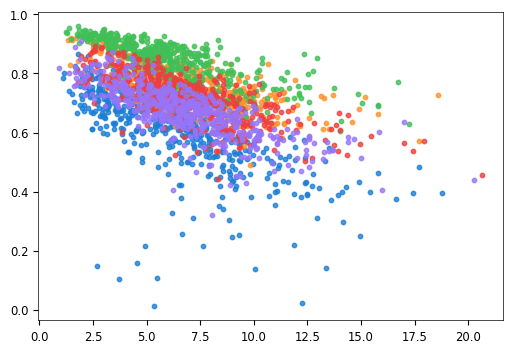

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
for grouper in merged_df['recrate_quantile'].unique():
    mdf = merged_df.loc[merged_df['recrate_quantile'] == grouper]
    ax.scatter(mdf['perc'], mdf['B'], s=10, alpha=0.8, )

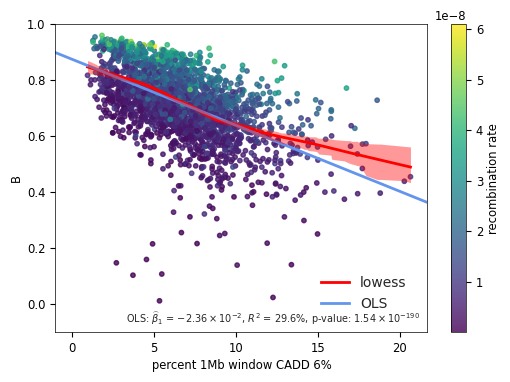

In [89]:
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['perc'], merged_df['B'], s=10, alpha=0.8, c=merged_df['recrate'])

lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['B'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2, label='lowess')

res = stats.linregress(merged_df['perc'], merged_df['B'])
ax.axline((0, res[1]), slope=res[0], linewidth=2, label=f'OLS', c='cornflowerblue')

# Add the regression line to the plot
#ax.plot(xp, xp/1e-8, c='0.77', linestyle='dashed', linewidth=0.8)
ax.text(0.98, 0.03, "OLS: " + ols_summary(res, None), transform=ax.transAxes, fontsize=7, ha='right')
ax.set_ylim(-0.1, 1)

ax.legend()
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('recombination rate')
ax.set_ylabel('B')
ax.set_xlabel('percent 1Mb window CADD 6%')
fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_B.pdf', bbox_inches='tight')

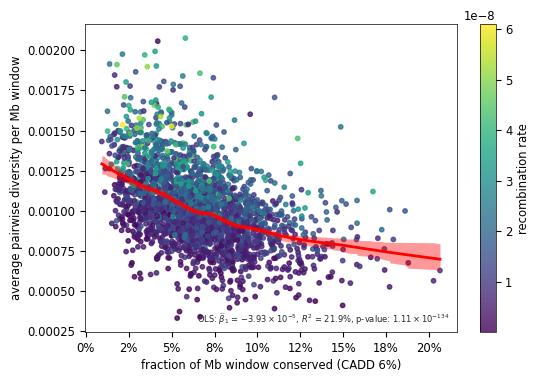

In [90]:

from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['perc'], merged_df['pi'], s=10, alpha=0.8, c=merged_df['recrate'])
lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['pi'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2)
res = stats.linregress(merged_df['perc'], merged_df['pi'])

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('recombination rate')

# Define a function to format the x-axis labels with percent signs
def percent_format(x, pos):
    return f'{x:.0f}%'

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(FuncFormatter(percent_format))

ax.set_ylabel('average pairwise diversity per Mb window')
ax.set_xlabel('fraction of Mb window conserved (CADD 6%)')
ax.text(0.98, 0.03, "OLS: " + ols_summary(res, None), transform=ax.transAxes, fontsize=6, ha='right')

fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_pi.pdf', bbox_inches='tight')

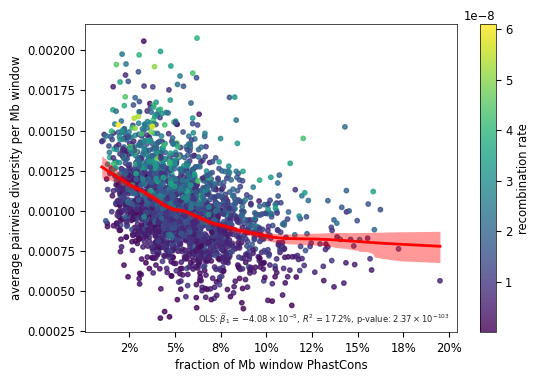

In [104]:

from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['perc_pc'], merged_df['pi'], s=10, alpha=0.8, c=merged_df['recrate'])
lw = Lowess(0.3)
lw.fit(merged_df['perc_pc'], merged_df['pi'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2)
res = stats.linregress(merged_df['perc_pc'], merged_df['pi'])

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('recombination rate')

# Define a function to format the x-axis labels with percent signs
def percent_format(x, pos):
    return f'{x:.0f}%'

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(FuncFormatter(percent_format))

ax.set_ylabel('average pairwise diversity per Mb window')
ax.set_xlabel('fraction of Mb window PhastCons')
ax.text(0.98, 0.03, "OLS: " + ols_summary(res, None), transform=ax.transAxes, fontsize=6, ha='right')

fig.savefig('../manuscript/figures/supplementary/suppfigure_pc_pi.pdf', bbox_inches='tight')

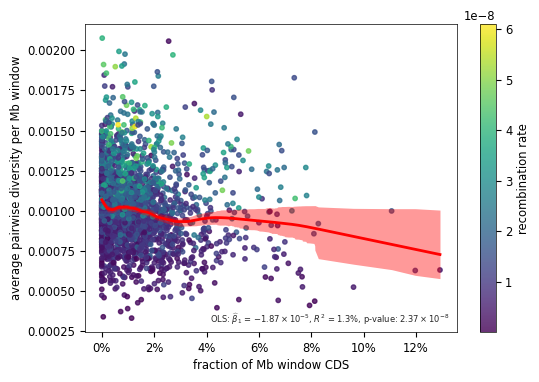

In [99]:

from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['perc_cds'], merged_df['pi'], s=10, alpha=0.8, c=merged_df['recrate'])
lw = Lowess(0.3)
lw.fit(merged_df['perc_cds'], merged_df['pi'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2)
res = stats.linregress(merged_df['perc_cds'], merged_df['pi'])

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('recombination rate')

# Define a function to format the x-axis labels with percent signs
def percent_format(x, pos):
    return f'{x:.0f}%'

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(FuncFormatter(percent_format))

ax.set_ylabel('average pairwise diversity per Mb window')
ax.set_xlabel('fraction of Mb window CDS')
ax.text(0.98, 0.03, "OLS: " + ols_summary(res, None), transform=ax.transAxes, fontsize=6, ha='right')

fig.savefig('../manuscript/figures/supplementary/suppfigure_cds_pi.pdf', bbox_inches='tight')

Text(0.98, 0.03, 'OLS: $\\widehat{\\beta}_1$ = $-3.63 \\times 10^{-5}$, $R^2$ = 24.1%, p-value: $3.25 \\times 10^{-150}$')

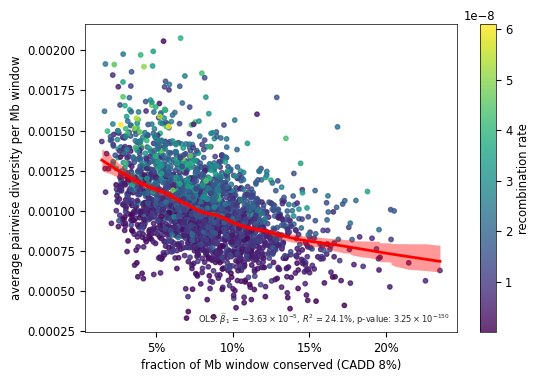

In [91]:

from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['perc_8'], merged_df['pi'], s=10, alpha=0.8, c=merged_df['recrate'])
lw = Lowess(0.3)
lw.fit(merged_df['perc_8'], merged_df['pi'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2)
res = stats.linregress(merged_df['perc_8'], merged_df['pi'])
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('recombination rate')

# Define a function to format the x-axis labels with percent signs
def percent_format(x, pos):
    return f'{x:.0f}%'

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(FuncFormatter(percent_format))

ax.set_ylabel('average pairwise diversity per Mb window')
ax.set_xlabel('fraction of Mb window conserved (CADD 8%)')
ax.text(0.98, 0.03, "OLS: " + ols_summary(res, None), transform=ax.transAxes, fontsize=6, ha='right')

#fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_pi.pdf', bbox_inches='tight')

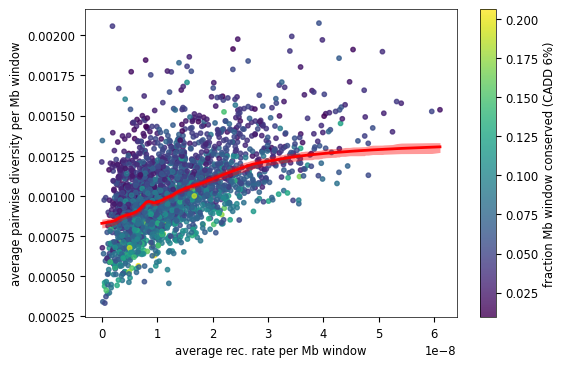

In [93]:

from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(6, 4))
scatter = ax.scatter(merged_df['recrate'], merged_df['pi'], s=10, alpha=0.8, c=merged_df['frac'])
lw = Lowess(0.2)
lw.fit(merged_df['recrate'], merged_df['pi'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

ax.plot(*lw.pairs(),  c='red', linewidth=2)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('fraction Mb window conserved (CADD 6%)')

ax.set_ylabel('average pairwise diversity per Mb window')
ax.set_xlabel('average rec. rate per Mb window')
fig.savefig('../manuscript/figures/supplementary/suppfigure_recrate_pi.pdf', bbox_inches='tight')

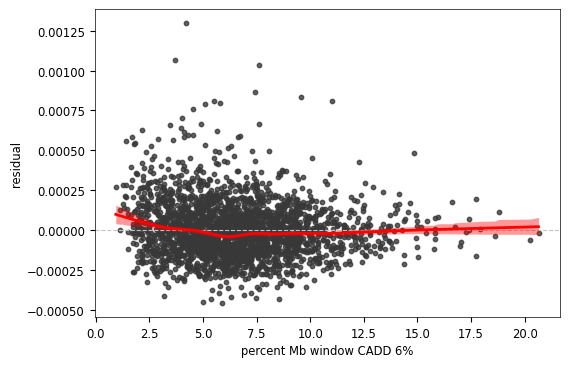

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(merged_df['perc'], merged_df['resid'], c='0.22', s=10, alpha=0.8, )
#ax.semilogx()
ax.axhline(0, c='0.77', linestyle='dashed', linewidth=0.8)
lw = Lowess(0.3)
lw.fit(merged_df['perc'], merged_df['resid'])
lb, ub = lw.bootstrap()
ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

plt.plot(*lw.pairs(),  c='red', linewidth=2)


ax.set_ylabel('residual')
ax.set_xlabel('percent Mb window CADD 6%')
fig.savefig('../manuscript/figures/supplementary/suppfigure_cadd_residual.pdf', 
            bbox_inches='tight')

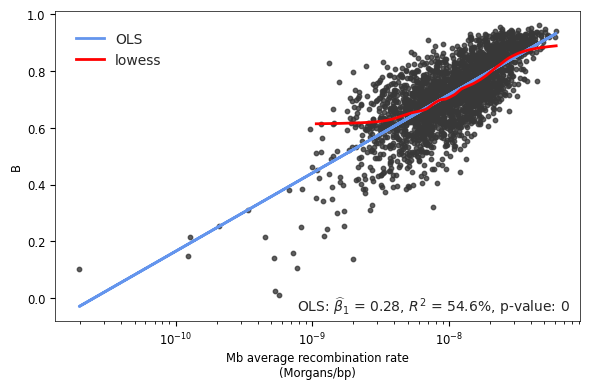

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(Mb_recrates, B, c='0.22', s=10, alpha=0.8)
ax.semilogx()
#ax.axhline(0, c='0.77', linestyle='dashed', linewidth=0.8)
lw = Lowess(0.3)
lw.fit(Mb_recrates, B)

#lb, ub = lw.bootstrap()
#ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

lw = Lowess(0.2)
xp, yp = np.array(Mb_recrates), np.array(B)
idx = xp > 1e-9
xp, yp = xp[idx], yp[idx]
lw.fit(xp, yp)
#lb, ub = lw.bootstrap()
#ax.fill_between(lw.x_, lb, ub, color='red', alpha=0.4, linewidth=0, zorder=19)

res = stats.linregress(np.log10(Mb_recrates), B)

slope, intercept, r_value, p_value, std_err = res

# Create line values
line = slope * np.log10(merged_df['recrate']) + intercept

ax.text(0.98, 0.03, "OLS: " + ols_summary(res), transform=ax.transAxes, fontsize=10, ha='right')
plt.plot(merged_df['recrate'], line, linewidth=2, color='cornflowerblue', label='OLS')

ax.plot(*lw.pairs(),  c='red', linewidth=2, label='lowess')

#plt.plot(*lw.pairs(),  c='red', linewidth=2)
ax.set_ylabel('B')
ax.legend()
ax.set_xlabel('Mb average recombination rate\n(Morgans/bp)')
fig.savefig('../manuscript/figures/supplementary/suppfigure_recrate_B.pdf', 
            bbox_inches='tight')

plt.tight_layout()

y = exp(-u/r)

y = a + b log(r)
exp(-u/r) = a + b log(r)
 
(r) = exp((u/r)**2 / b)
r = exp((u/r)**2) - exp(b)

In [26]:
res

LinregressResult(slope=0.2751590796766107, intercept=2.9166949859436473, rvalue=0.7391176832873761, pvalue=0.0, stderr=0.005044529770678274, intercept_stderr=0.040332670635200206)

exp(-U) - exp(R) = a + b log(R)

Text(0.5, 0, 'recombination rate')

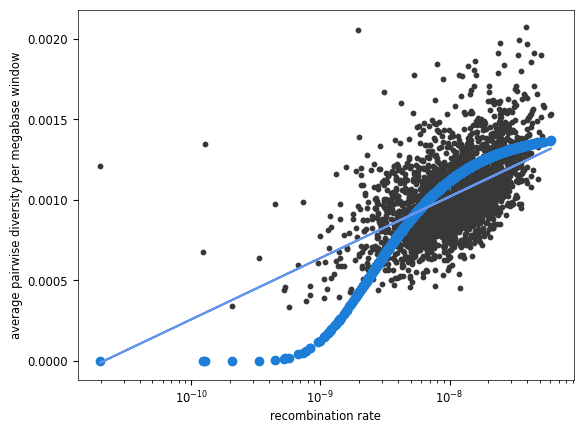

In [27]:
plt.scatter(merged_df['recrate'], merged_df['pi'], c='0.22', s=10)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(merged_df['recrate']), 
                                                              merged_df['pi'])

# Create line values
line = slope * np.log10(merged_df['recrate']) + intercept

# Add the regression line to the plot
plt.plot(merged_df['recrate'], line, color='cornflowerblue', 
        label=f'OLS: y={slope:.2f}x+{intercept:.2f}')

rr = merged_df['recrate'].values
plt.scatter(rr, c6['mbp'].mle_pi0 * np.exp(-2*2e-8*0.06*1e6/(rr*1e6)))
plt.semilogx()
plt.ylabel("average pairwise diversity per megabase window")
plt.xlabel("recombination rate")

In [28]:
from scipy.optimize import least_squares
pi0 = c6['mbp'].mle_pi0

def objective(params):
    mu, sh = params
    pred_pi = pi0 * np.exp(-2*mu*0.06*1e6/(rr*1e6 + 2*sh))
    return np.sum((pi - pred_pi)**2)

# Initial guesses for a and b
initial_guess = [1e-8, 0.001]

# Perform the optimization
result = least_squares(objective, initial_guess)

In [29]:
result

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.198e-04]
           x: [ 2.526e-08  1.000e-03]
        cost: 7.171726892834246e-09
         jac: [[ 1.349e+03  1.844e-03]]
        grad: [ 1.615e-01  2.209e-07]
  optimality: 0.16154486500356485
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 17
        njev: 2

In [30]:
mu, sh = result.x
pred_pi = pi0 * np.exp(-2*mu*0.06*1e6/(rr*1e6 + 2*sh))

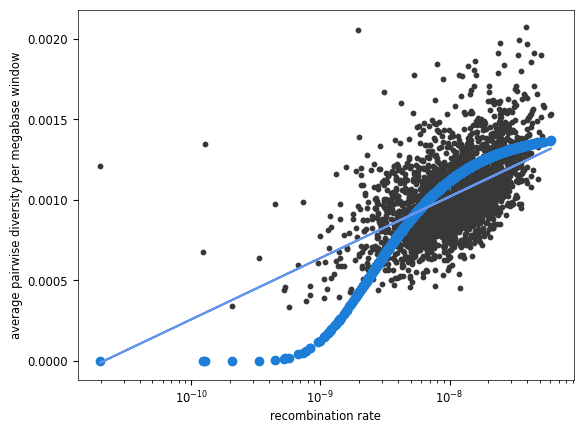

In [31]:
plt.scatter(merged_df['recrate'], merged_df['pi'], c='0.22', s=10)
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(merged_df['recrate']), 
                                                              merged_df['pi'])

# Create line values
line = slope * np.log10(merged_df['recrate']) + intercept

# Add the regression line to the plot
plt.plot(merged_df['recrate'], line, color='cornflowerblue', 
        label=f'OLS: y={slope:.2f}x+{intercept:.2f}')

rr = merged_df['recrate'].values
plt.scatter(rr, c6['mbp'].mle_pi0 * np.exp(-2*2e-8*0.06*1e6/(rr*1e6)))
plt.semilogx()
plt.ylabel("average pairwise diversity per megabase window")
plt.xlabel("recombination rate")
plt.scatter(np.log10(rr), pred_pi)

In [32]:
slope, intercept

(0.0003809049368015543, 0.00406754071660471)

pi0 exp(-U) - pi0 exp(R) = a + b log(R)

In [33]:
a, b = slope, intercept / c6['mbp'].mle_pi0

In [34]:
# here a = intercept / pi0 = exp(-U)
# and b = slope / pi0 = exp(R)
a, b

(0.0003809049368015543, 2.8561122037058575)

In [35]:
-np.log10(a) / 1e6, -np.log10(slope) / 1e6

(3.419183398534173e-06, 3.419183398534173e-06)

Let's look now at these high outliers.

In [36]:
d.iloc[(resid > 0.001)]

,chrom,start,end,resid,B,recrate,pi
120,chr1,148000000,149000000,0.001037,0.216247,1.272222e-10,0.001345
1000,chr6,29000000,30000000,0.001298,0.532646,1.941593e-09,0.002057
1434,chr9,63000000,64000000,0.001064,0.103291,1.967209e-11,0.001211


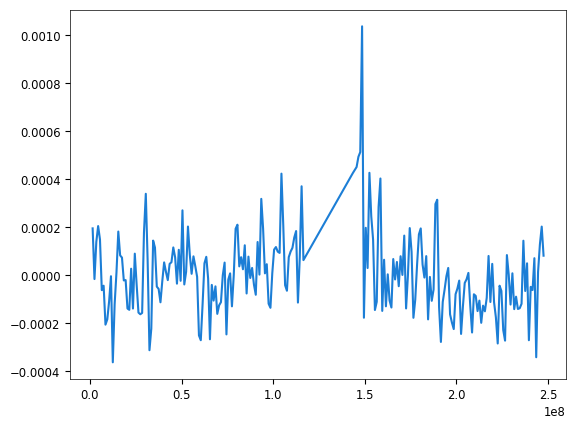

In [37]:
plt.plot(allbins.midpoints()['chr1'], c6['mbp'].resid()[allbins.chrom_indices('chr1')])

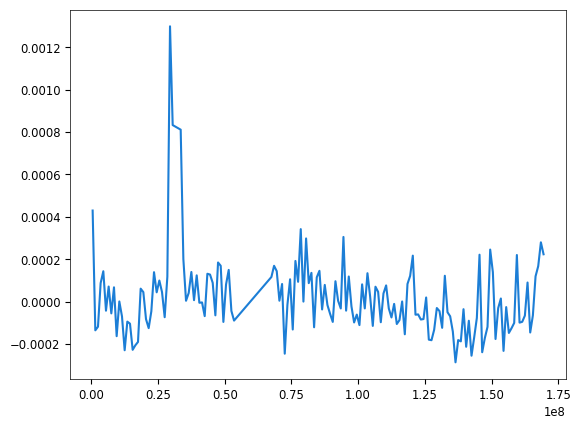

In [38]:
plt.plot(allbins.midpoints()['chr6'], c6['mbp'].resid()[allbins.chrom_indices('chr6')])

Positive residuals = observation > prediction, e.g. excess of $\pi$ compared to prediction. This is MHC. 

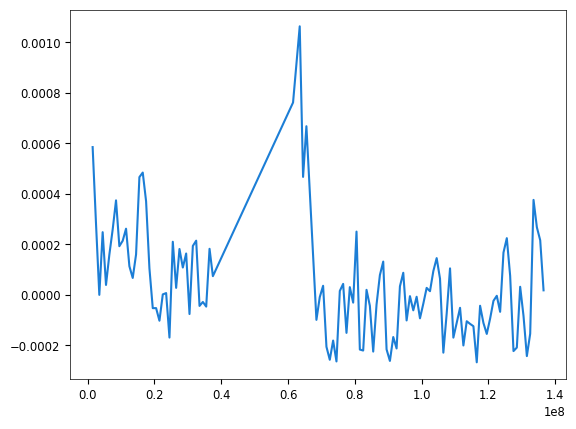

In [39]:
plt.plot(allbins.midpoints()['chr9'], c6['mbp'].resid()[allbins.chrom_indices('chr9')])

So most look centromere-related. 

One reviewer asked about feature priority model DFEs — here are some quick calcs.

In [45]:
cds = np.array((0.148, 0.516, 0.522))
pc = np.array((0.929, 0.834, 0.964))
cds.mean(), pc.mean(), cds.mean() / pc.mean()

(0.3953333333333333, 0.9089999999999999, 0.4349101576824349)

In [46]:
0.9089999999999999 * 0.3

0.27269999999999994

## B' and B comparisions

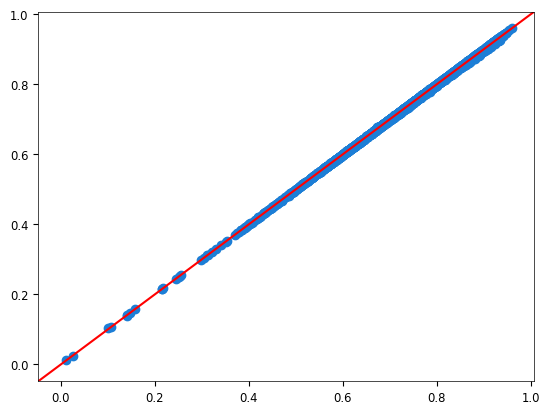

In [127]:
mb, mbp = c6['mb'].predict(B=True), c6['mbp'].predict(B=True)
plt.scatter(mb, mbp)
plt.axline((0, 0), slope=1, c='r')
res = stats.linregress(mb, mbp)


In [130]:
res = stats.linregress(c6['mb'].predict(), c6['mbp'].predict())
res, res.rvalue**2

(LinregressResult(slope=1.0000960315759944, intercept=-4.481486447259833e-08, rvalue=0.9999582892602497, pvalue=0.0, stderr=0.00018376291086891496, intercept_stderr=1.907309856206258e-07),
 0.9999165802602851)

Text(0.5, 0, '')

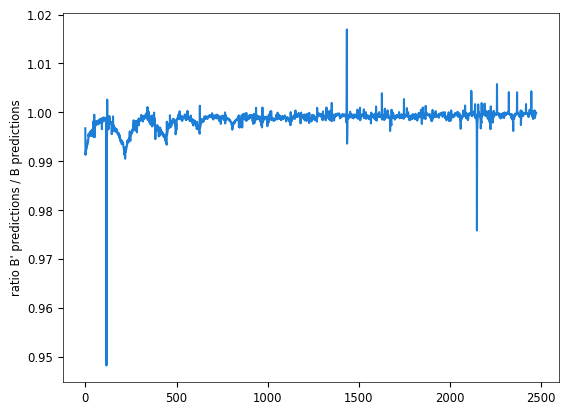

In [131]:
fig, ax = plt.subplots()
ax.plot(mbp/mb)
ax.set_ylabel("ratio B' predictions / B predictions")
ax.set_xlabel("")

In [132]:
merged_df['pred_b'] = mb
merged_df['pred_bp'] = mbp

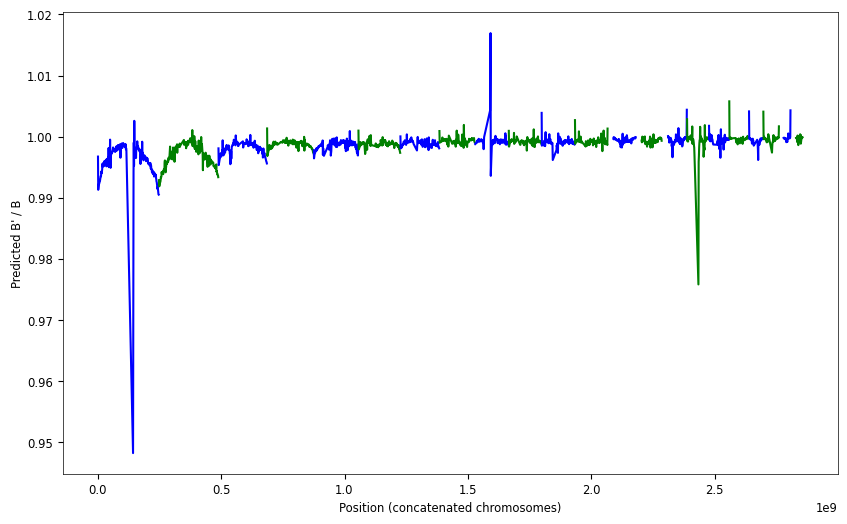

In [135]:
merged_df['ratio'] = merged_df['pred_bp'] / merged_df['pred_b']

# Calculate the mid-point of each region for plotting
merged_df['mid'] = (merged_df['start'] + merged_df['end']) / 2

# Create a new column for the x-axis position
merged_df['x_pos'] = 0
current_pos = 0

# Colors for alternating
colors = ['blue', 'green']

for chrom in merged_df['chrom'].unique():
    # Filter the dataframe for the current chromosome
    chrom_df = merged_df[merged_df['chrom'] == chrom]
    
    # Update positions
    merged_df.loc[merged_df['chrom'] == chrom, 'x_pos'] = chrom_df['mid'] + current_pos
    current_pos += chrom_df['end'].max()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, chrom in enumerate(merged_df['chrom'].unique()):
    # Filter for each chromosome
    chrom_df = merged_df[merged_df['chrom'] == chrom]
    
    # Scatter plot for each chromosome
    ax.plot(chrom_df['x_pos'], chrom_df['ratio'], color=colors[i % len(colors)], label=f'Chrom {chrom}')

# Labels and title
ax.set_xlabel('Position (concatenated chromosomes)')
ax.set_ylabel("Predicted B' / B")
#ax.set_title('Manhattan-like Plot')
fig.savefig('../manuscript/figures/supplementary/suppfigure_bp_b_ratio.pdf', bbox_inches='tight')

In [137]:
mb.mean(), mbp.mean()

(0.7195655188958219, 0.7185561867983739)

## Comparisons of CADD 6% across pops

In [138]:
c6_yri = c6
c6_ceu = load_pickle('../new_fits/cadd6__decode/fits/pop_ceu/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')
c6_chb = load_pickle('../new_fits/cadd6__decode/fits/pop_chb/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')


In [139]:
mods = dict(yri=c6_yri, ceu=c6_ceu, chb=c6_chb)

In [147]:
bmaps = {p: m['mbp'].predict(B=True) for p, m in mods.items()}

yri yri 1.0
yri ceu 0.899978858130912
yri chb 0.8398727037643939
ceu yri 0.8999788581309119
ceu ceu 1.0
ceu chb 0.917379273132921
chb yri 0.8398727037643939
chb ceu 0.917379273132921
chb chb 0.9999999999999998


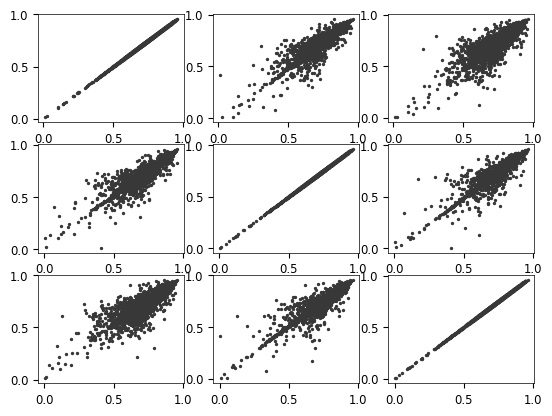

In [152]:
fig, ax = plt.subplots(nrows=3, ncols=3)
for i, popa in enumerate(bmaps):
    for j, popb in enumerate(bmaps):
        ax[i,j].scatter(bmaps[popa], bmaps[popb], c='0.22', s=2)
        print(popa, popb, np.corrcoef(bmaps[popa], bmaps[popb])[0, 1])

cov

In [153]:
cov

,chrom,start,end,nfeature,nbases,length_a,frac,frac_8,frac_cds,frac_pc
0,chr1,0,1000000,10023,34068,1000000,0.034068,0.046515,0.015009,0.047037
1,chr1,1000000,2000000,17955,69224,1000000,0.069224,0.076089,0.067120,0.057837
2,chr1,2000000,3000000,9186,41676,1000000,0.041676,0.047313,0.026020,0.036746
3,chr1,3000000,4000000,12191,56600,1000000,0.056600,0.063421,0.026595,0.051037
4,chr1,4000000,5000000,7089,31176,1000000,0.031176,0.038398,0.001241,0.024830
...,...,...,...,...,...,...,...,...,...,...
2882,chr22,46000000,47000000,11196,42601,1000000,0.042601,0.048726,0.028410,0.032202
2883,chr22,47000000,48000000,5266,23599,1000000,0.023599,0.030123,0.000356,0.019649
2884,chr22,48000000,49000000,3743,18125,1000000,0.018125,0.022410,0.000677,0.017926
2885,chr22,49000000,50000000,5717,26564,1000000,0.026564,0.031405,0.011895,0.029092


In [173]:
cov['frac_cadd8'] = cov8['frac']
cov['frac_cds'] = cds['frac']
cov['frac_pc'] = pc['frac']
d = pd.DataFrame(allbins.flat_bins(), columns=('chrom', 'start', 'end'))
d['B_yri'] = c6_yri['mbp'].predict(B=True)
d['B_ceu'] = c6_ceu['mbp'].predict(B=True)
d['B_chb'] = c6_chb['mbp'].predict(B=True)
d['ave_recrate'] = Mb_recrates 
d['pi_yri'] = c6_yri['mbp'].pi()
d['pi_ceu'] = c6_ceu['mbp'].pi()
d['pi_chb'] = c6_chb['mbp'].pi()
d.set_index(['chrom', 'start', 'end'])


d['start'] = d['start'].astype('int64')
d['end'] = d['end'].astype('int64')
merged_df = pd.merge(d, cov, on=['chrom', 'start', 'end'], how='inner')

In [174]:
new_df = merged_df.drop(columns=['nfeature', 'nbases', 'frac_8', 'length_a', 'frac'])
new_df.head()

,chrom,start,end,B_yri,B_ceu,B_chb,ave_recrate,pi_yri,pi_ceu,pi_chb,frac_cds,frac_pc,frac_cadd8
0,chr1,1000000,2000000,0.500920,0.525042,0.536349,3.894731e-09,0.000909,0.000702,0.000790,0.067120,0.057837,0.076089
1,chr1,2000000,3000000,0.860676,0.858070,0.856398,1.489090e-08,0.001210,0.000919,0.001002,0.026020,0.036746,0.047313
2,chr1,3000000,4000000,0.901748,0.903779,0.906628,4.890751e-08,0.001423,0.000978,0.001083,0.026595,0.051037,0.063421
3,chr1,4000000,5000000,0.903248,0.905672,0.909161,2.477152e-08,0.001491,0.001256,0.001253,0.001241,0.024830,0.038398
4,chr1,5000000,6000000,0.886551,0.888976,0.892209,2.402526e-08,0.001412,0.000999,0.000850,0.004473,0.026533,0.039460


In [176]:
new_df.to_csv('../data/cadd6_summary.tsv', sep='\t', index=False)